In [ ]:
pip install d2l==0.17.1

**LeNet**  
LeNet (LeNet-5) consists of two parts: (i) a convolutional encoder consisting of
two convolutional layers; and (ii) a dense block consisting of three fully-connected layers; The
architecture is summarized in Fig. 6.6.1.  
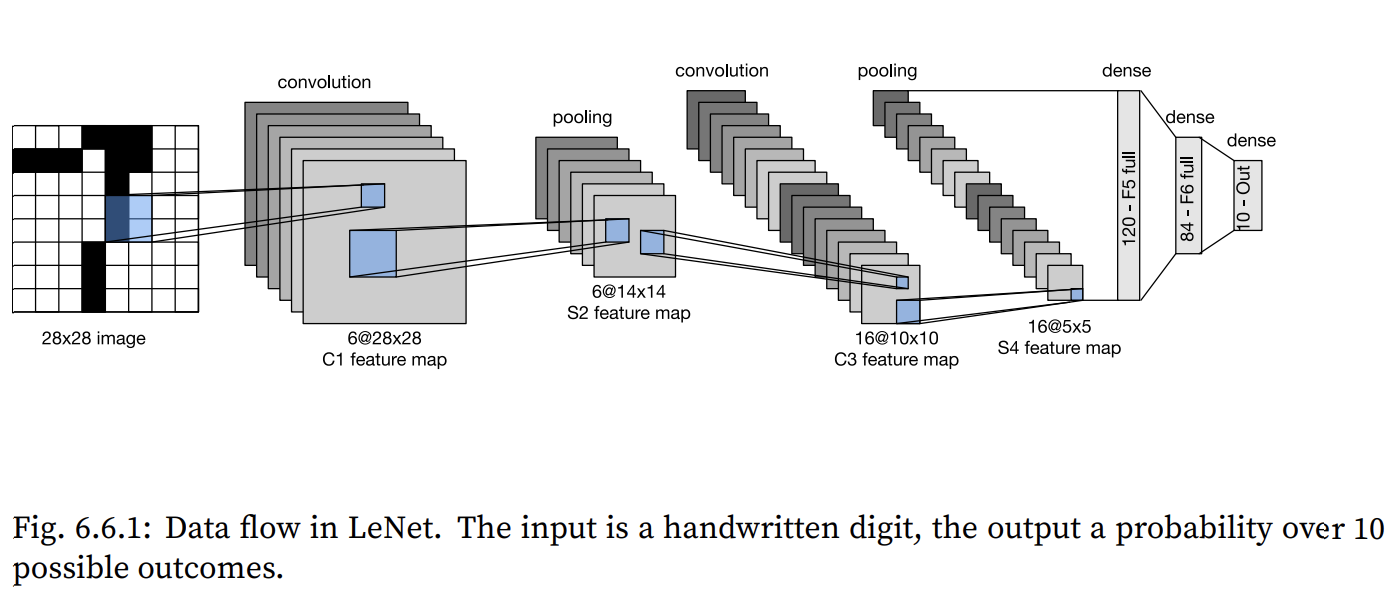


In each convolutional block, there is a convolutional layer with a $5\times5$ kernel, a sigmoid activation function and a subsequent update $2\times2$ average pooling operation.

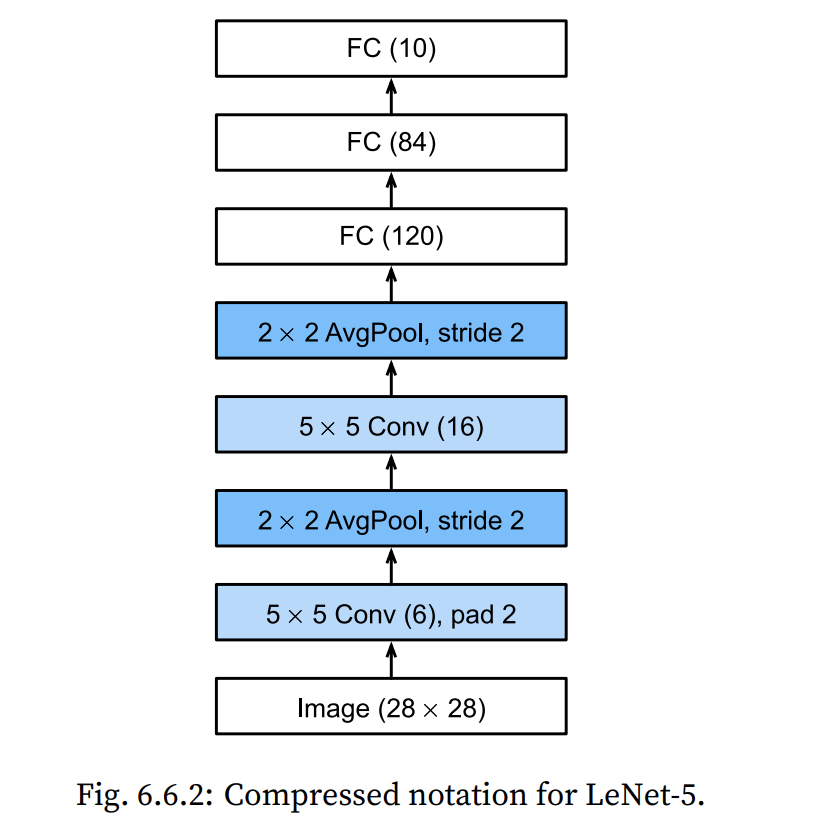

In [3]:
import torch
from torch import nn
from d2l import torch as d2l

In [4]:
class Reshape(torch.nn.Module):
  def forward(self, x):
    return x.view(-1, 1, 28, 28)

net = nn.Sequential(
    Reshape(), nn.Conv2d(1, 6, kernel_size=5, padding=2), nn.Sigmoid(), 
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Flatten(),
    nn.Linear(400, 120), nn.Sigmoid(),
    nn.Linear(120, 84), nn.Sigmoid(),
    nn.Linear(84, 10)
)

In [5]:
X = torch.rand((1, 1, 28, 28), dtype=torch.float32)
for layer in net:
  X = layer(X)
  print(layer.__class__.__name__, 'output shape: \t', X.shape)

Reshape output shape: 	 torch.Size([1, 1, 28, 28])
Conv2d output shape: 	 torch.Size([1, 6, 28, 28])
Sigmoid output shape: 	 torch.Size([1, 6, 28, 28])
AvgPool2d output shape: 	 torch.Size([1, 6, 14, 14])
Conv2d output shape: 	 torch.Size([1, 16, 10, 10])
Sigmoid output shape: 	 torch.Size([1, 16, 10, 10])
AvgPool2d output shape: 	 torch.Size([1, 16, 5, 5])
Flatten output shape: 	 torch.Size([1, 400])
Linear output shape: 	 torch.Size([1, 120])
Sigmoid output shape: 	 torch.Size([1, 120])
Linear output shape: 	 torch.Size([1, 84])
Sigmoid output shape: 	 torch.Size([1, 84])
Linear output shape: 	 torch.Size([1, 10])


**Training**

In [6]:
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size=batch_size)

In [7]:
def evaluate_accuracy_gpu(net, data_iter, device=None):
  # compute the accuracy for a model on a dataset using a GPU
  if isinstance(net, nn.Module):
    net.eval()
    if not device:
      device = next(iter(net.parameters())).device
  metric = d2l.Accumulator(2)

  with torch.no_grad():
    for X, y in data_iter:
      if isinstance(X, list):
        X = [x.to(device) for x in X]
      else:
        X = X.to(device)
      y = y.to(device)
      metric.add(d2l.accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

In [8]:
def train_lenet(net, train_iter, test_iter, num_epochs, lr, device):
  # train a model with a GPU
  def init_weights(m):
    if type(m) == nn.Linear or type(m) == nn.Conv2d:
      nn.init.xavier_uniform_(m.weight)
  net.apply(init_weights)
  print('Training on ', device)
  net.to(device)
  optimizer = torch.optim.SGD(net.parameters(), lr=lr)
  loss = nn.CrossEntropyLoss()
  animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs], 
                          legend=['train loss', 'train acc', 'test acc'])
  timer, num_batches = d2l.Timer(), len(train_iter)
  for epoch in range(num_epochs):
    metric = d2l.Accumulator(3)
    net.train()
    for i, (X, y) in enumerate(train_iter):
      timer.start()
      optimizer.zero_grad()
      X, y = X.to(device), y.to(device)
      y_hat = net(X)
      l = loss(y_hat, y)
      l.backward()
      optimizer.step()
      with torch.no_grad():
        metric.add(l * X.shape[0], d2l.accuracy(y_hat, y), X.shape[0])
      timer.stop()
      train_l = metric[0] / metric[2]
      train_acc = metric[1] / metric[2]
      if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
        animator.add(epoch + (i + 1) / num_batches,
                     (train_l, train_acc, None))
    test_acc = evaluate_accuracy_gpu(net, test_iter)
    animator.add(epoch + 1, (None, None, test_acc))
  print(f'loss {train_l:.3f}, train acc {train_acc:.3f}, 'f'test acc {test_acc:.3f}')
  print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec 'f'on {str(device)}')

loss 0.360, train acc 0.866, test acc 0.855
57028.8 examples/sec on cuda:0


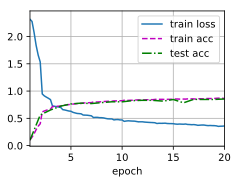

In [11]:
lr, num_epochs = 0.9, 20
train_lenet(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

**Summary**:  
1. A CNN is a network that employs convolutional layers.
2. In a CNN, we interleave convolutions, nonlinearities, and (often) pooling operations.
3. In a CNN, convolutional layers are typically arranged so that they gradually **decrease the
spatial resolution of the representations**, while **increasing the number of channels**.
4. In traditional CNNs, the representations encoded by the convolutional blocks are processed
by one or more fully-connected layers prior to emitting output.
5. LeNet was arguably the first successful deployment of such a network.